In [1]:
from platform import python_version
print(python_version())

3.10.14


In [2]:
from tensorflow.python.framework.test_util import is_gpu_available

print("Is GPU available:", is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

True

In [5]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
# from google.colab import drive
import random
import os
import scipy
from sklearn.model_selection import train_test_split

In [7]:
# Set paths to your data directories
# import os
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset directory
data_dir = 'D:\\AI in Cytopathology\\Dataset\\COVID\\COVID-19_Radiography_Dataset'
print(data_dir)

D:\AI in Cytopathology\Dataset\COVID\COVID-19_Radiography_Dataset


In [8]:
# Get all image paths and their respective class labels
image_paths = []
class_labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
            image_paths.append(os.path.join(root, file))
            class_labels.append(os.path.basename(root))  # Assuming folder name is the label

In [9]:
# Create a DataFrame with image paths and labels
data_df = pd.DataFrame({
    'filename': image_paths,
    'class': class_labels
})

In [10]:
# Split data into train (60%), validation (20%), and test (20%)
train_df, temp_df = train_test_split(data_df, test_size=0.4, stratify=data_df['class'], random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

In [11]:
# ImageDataGenerator for data augmentation (only on the training set)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# ImageDataGenerator for validation and test data (only rescaling)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from DataFrame for train, validation, and test sets
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_val_datagen.flow_from_dataframe(
    validation_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)

# Check class indices for sanity check
print("Class indices:", train_generator.class_indices)


Found 12699 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Found 4233 validated image filenames belonging to 4 classes.
Class indices: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example generators (replace these with your actual generators)
# train_generator, validation_generator, test_generator

# Extract class counts for train, validation, and test generators
train_class_counts = pd.Series(train_generator.classes).value_counts()
val_class_counts = pd.Series(validation_generator.classes).value_counts()
test_class_counts = pd.Series(test_generator.classes).value_counts()

# Debug prints to verify extracted class counts
print("Train class counts:\n", train_class_counts)
print("Validation class counts:\n", val_class_counts)
print("Test class counts:\n", test_class_counts)

# Ensure all classes are represented, even if they have 0 count in some generators
all_classes = sorted(train_generator.class_indices.keys())
print("All classes:", all_classes)

# Create DataFrames for each generator with a new column indicating the generator type
df_train = pd.DataFrame({
    'Class': all_classes,
    'Count': [train_class_counts.get(cls, 0) for cls in all_classes],
    'Generator': 'Train'
})
df_val = pd.DataFrame({
    'Class': all_classes,
    'Count': [val_class_counts.get(cls, 0) for cls in all_classes],
    'Generator': 'Validation'
})
df_test = pd.DataFrame({
    'Class': all_classes,
    'Count': [test_class_counts.get(cls, 0) for cls in all_classes],
    'Generator': 'Test'
})

Train class counts:
 2    6115
1    3607
0    2170
3     807
Name: count, dtype: int64
Validation class counts:
 2    2039
1    1202
0     723
3     269
Name: count, dtype: int64
Test class counts:
 2    2038
1    1203
0     723
3     269
Name: count, dtype: int64
All classes: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


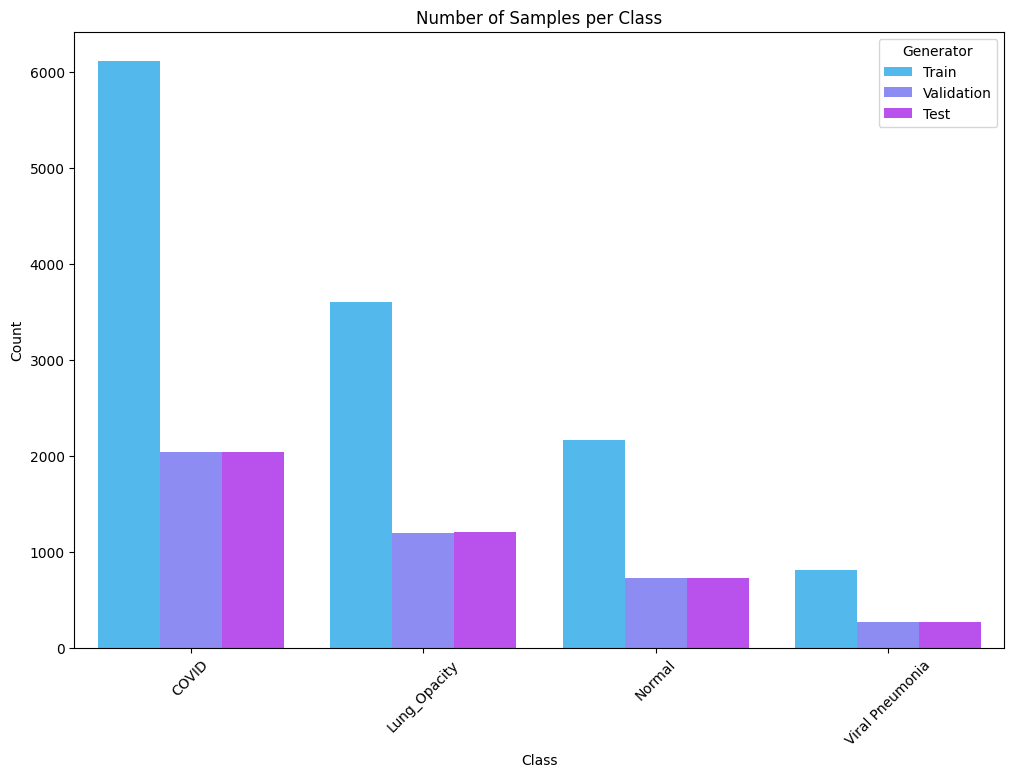

In [13]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# Extract class counts for train, validation, and test generators
train_class_counts = pd.Series(train_generator.classes).value_counts()
val_class_counts = pd.Series(validation_generator.classes).value_counts()
test_class_counts = pd.Series(test_generator.classes).value_counts()

# Create DataFrames for each generator with a new column indicating the generator type
df_train = pd.DataFrame({
    'Class': list(train_generator.class_indices.keys()),
    'Count': train_class_counts,
    'Generator': 'Train'
})
df_val = pd.DataFrame({
    'Class': list(validation_generator.class_indices.keys()),
    'Count': val_class_counts,
    'Generator': 'Validation'
})
df_test = pd.DataFrame({
    'Class': list(test_generator.class_indices.keys()),
    'Count': test_class_counts,
    'Generator': 'Test'
})

# Concatenate the three DataFrames
df_merged = pd.concat([df_train, df_val, df_test])

# Plotting the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=df_merged, x='Class', y='Count', hue='Generator', palette='cool', saturation=0.8)
plt.title('Number of Samples per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Generator')
plt.show()

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

def plot_images_from_df(data_df, title, n_images=1):
    """Plots 1 random image from each class in the provided DataFrame."""
    # Get unique classes
    classes = data_df['class'].unique()
    
    plt.figure(figsize=(15, 10))  # Adjust figure size
    
    for i, cls in enumerate(classes):
        # Filter images for the current class
        class_images = data_df[data_df['class'] == cls]['filename'].values
        
        # Randomly select 1 image from the class
        selected_images = random.sample(list(class_images), 1)  # Select only 1 image per class
        
        for j, img_path in enumerate(selected_images):
            # Read and plot the image using Pillow
            try:
                img = Image.open(img_path)
                plt.subplot(1, len(classes), i + 1)  # Plot images in a single row
                plt.imshow(img)
                plt.title(cls)
                plt.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    # Reduce the space between title and images
    plt.suptitle(title, fontsize=16, y=0.85)  # Adjust 'y' value to reduce the gap
    plt.subplots_adjust(top=0.75, wspace=0.05, hspace=0)  # Adjust 'top' value to bring title closer to images
    plt.show()

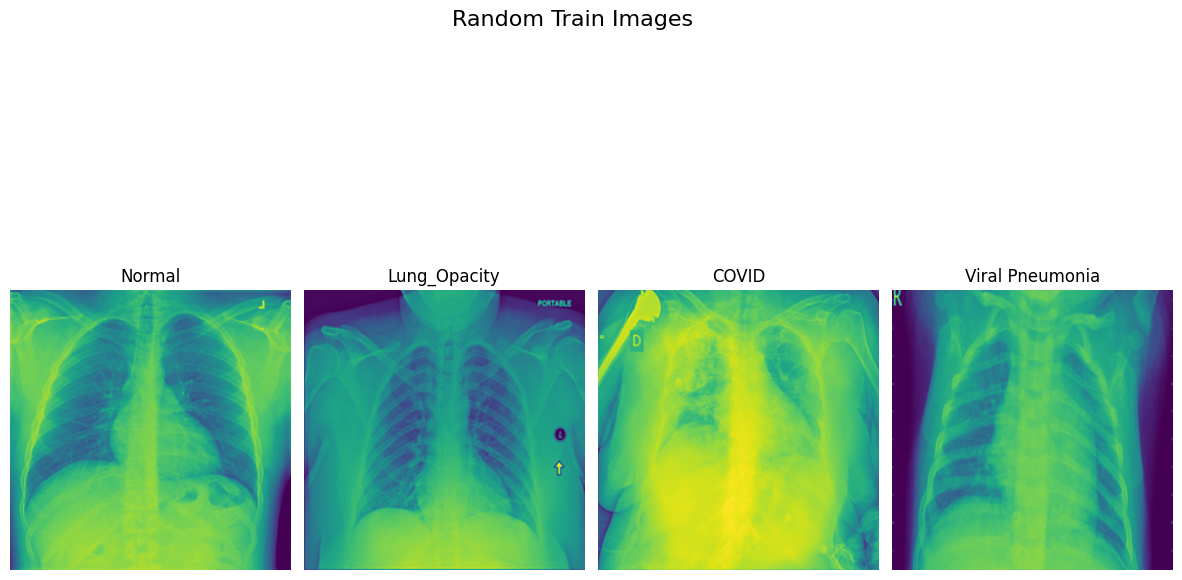

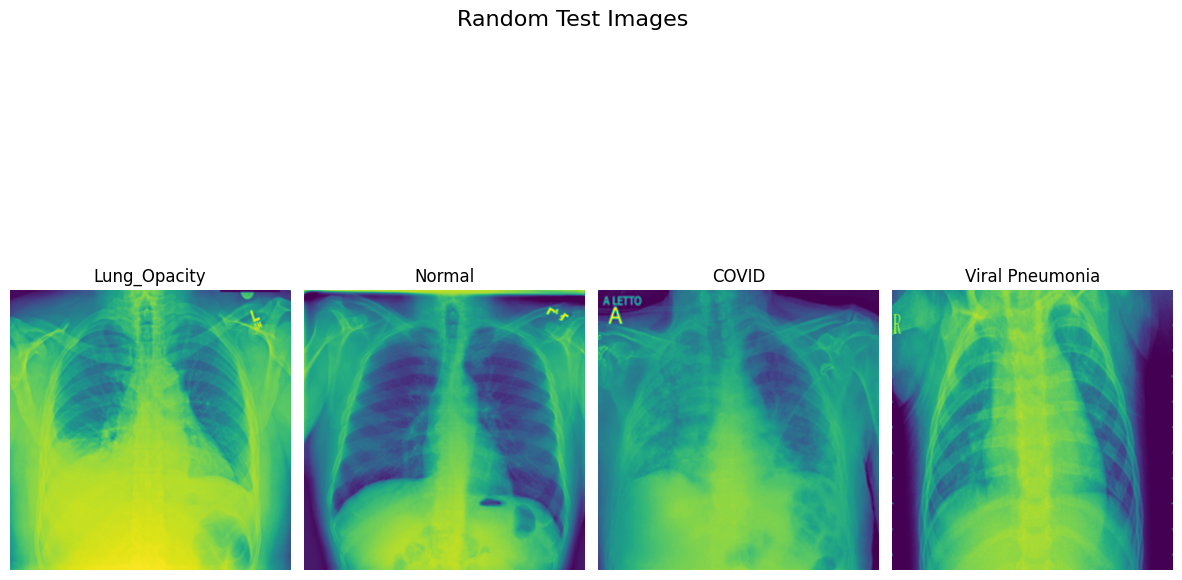

In [15]:
# Plot train images
plot_images_from_df(train_df, title='Random Train Images')

# Plot test images
plot_images_from_df(test_df, title='Random Test Images')


In [16]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Load VGG19 model with pretrained ImageNet weights
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of VGG19
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# Retrieve number of classes from train_generator
num_classes = len(train_generator.class_indices)  # Correct way to get the number of classes

# Output layer with the correct number of classes
output = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
# base_model.summary()

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model = model,show_shapes= True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [21]:
import scipy
print(scipy.__version__)

1.14.0


In [22]:
from PIL import Image

In [23]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/50
1588/1588 [==============================] - 199s 120ms/step - loss: 0.9119 - accuracy: 0.6279 - val_loss: 0.7003 - val_accuracy: 0.6995
Epoch 2/50
1588/1588 [==============================] - 205s 129ms/step - loss: 0.7456 - accuracy: 0.6976 - val_loss: 0.5534 - val_accuracy: 0.7921
Epoch 3/50
1588/1588 [==============================] - 230s 145ms/step - loss: 0.6917 - accuracy: 0.7264 - val_loss: 0.5783 - val_accuracy: 0.7829
Epoch 4/50
1588/1588 [==============================] - 185s 116ms/step - loss: 0.6604 - accuracy: 0.7405 - val_loss: 0.5011 - val_accuracy: 0.8183
Epoch 5/50
1588/1588 [==============================] - 184s 116ms/step - loss: 0.6271 - accuracy: 0.7538 - val_loss: 0.4807 - val_accuracy: 0.8205
Epoch 6/50
1588/1588 [==============================] - 185s 116ms/step - loss: 0.6126 - accuracy: 0.7573 - val_loss: 0.4698 - val_accuracy: 0.8131
Epoch 7/50
1588/1588 [==============================] - 186s 117ms/step - loss: 0.5987 - accuracy: 0.7643 - val_

In [24]:
model.save('D:\\AI in Cytopathology\\Dataset\\COVID\\ChestX-Ray.h5')

In [25]:
# Evaluate the model on train, validation, and test data
train_accuracy = model.evaluate(train_generator)[1]
val_accuracy = model.evaluate(validation_generator)[1]
test_accuracy = model.evaluate(test_generator)[1]

# Print the final train, validation, and test accuracy
print("Final Train Accuracy:", train_accuracy)
print("Final Validation Accuracy:", val_accuracy)
print("Final Test Accuracy:", test_accuracy)

530/530 [==============================] - 41s 76ms/step - loss: 0.3601 - accuracy: 0.8635
Final Train Accuracy: 0.8366013169288635
Final Validation Accuracy: 0.8632175922393799
Final Test Accuracy: 0.8634538054466248


In [26]:
def plot_images_from_df(data_df, title, n_images=5):
    """Plots n_images random images from each class in the provided DataFrame."""
    # Get unique classes
    classes = data_df['class'].unique()
    
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(classes):
        # Filter images for the current class
        class_images = data_df[data_df['class'] == cls]['filename'].values
        
        # Randomly select n_images from the class
        selected_images = random.sample(list(class_images), min(n_images, len(class_images)))
        
        for j, img_path in enumerate(selected_images):
            # Read and plot the image
            img = plt.imread(img_path)
            plt.subplot(len(classes), n_images, i * n_images + j + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [27]:
# Accuracy and Loss Graphs
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

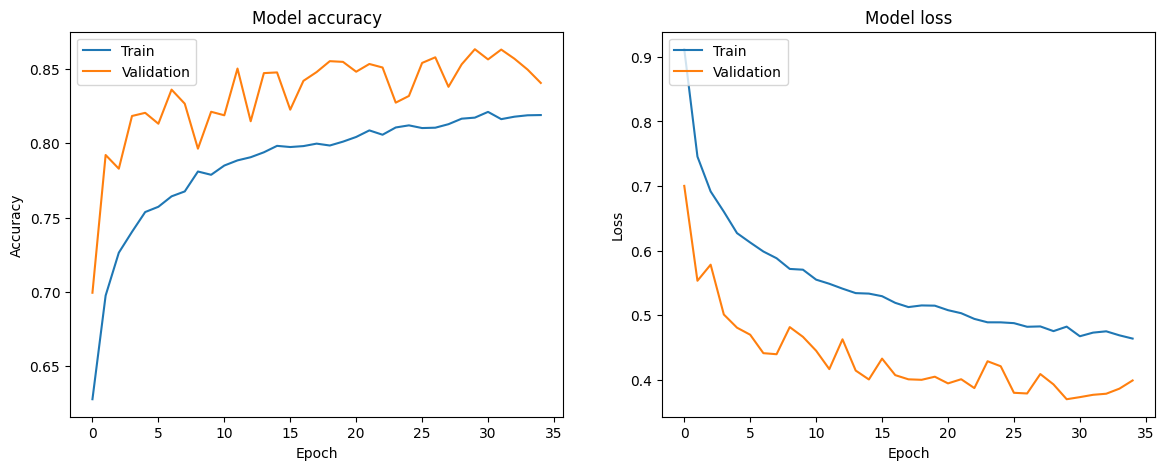

In [28]:
plot_history(history)

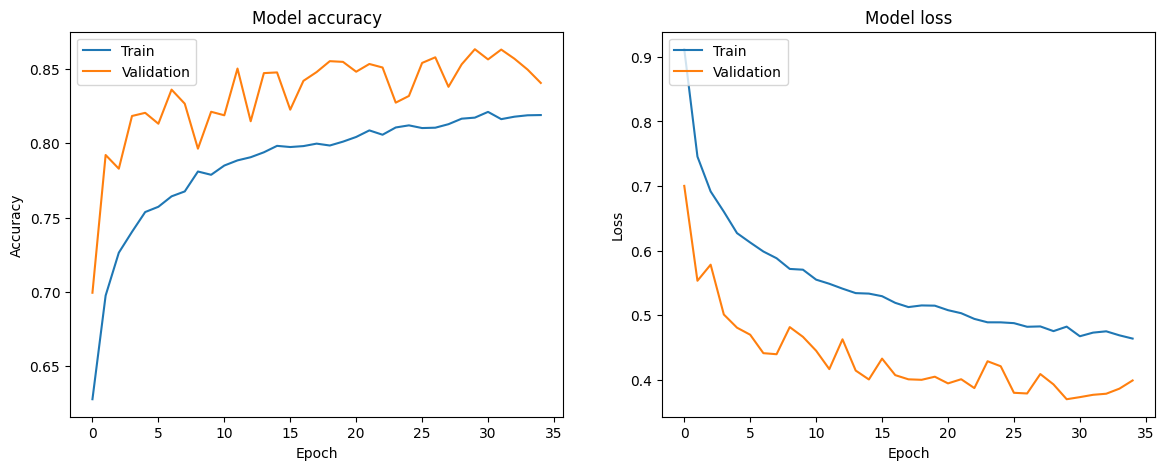

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history object
# Call your plot_history function
plot_history(history)

# Specify the path where you want to save the SVG file
save_path = 'D:\\AI in Cytopathology\\Dataset\\COVID\\model loss and accuracy.svg'

# Save the plot to SVG
plt.savefig(save_path, format='svg')


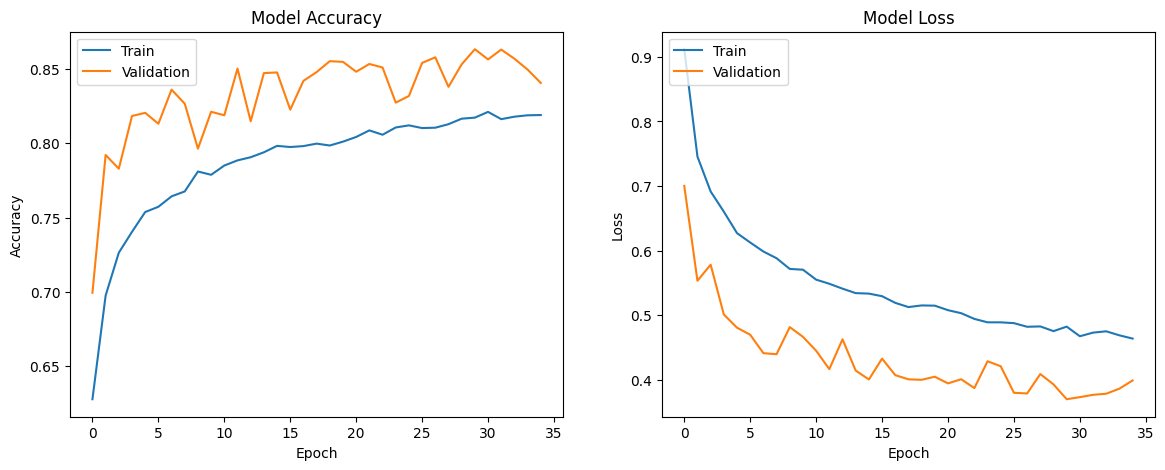

In [30]:
import matplotlib.pyplot as plt

def plot_history(history, save_path):
    # Create a figure with a specific size
    plt.figure(figsize=(14, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Save the figure to an SVG file
    plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()

# Assuming 'history' is your training history object
# Specify the path where you want to save the SVG file
save_path = 'D:\\AI in Cytopathology\\Dataset\\COVID\\model loss and accuracy.svg'

# Call the plot_history function with the history object and the save path
plot_history(history, save_path)

In [31]:
# Evaluate the model
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

530/530 [==============================] - 40s 74ms/step


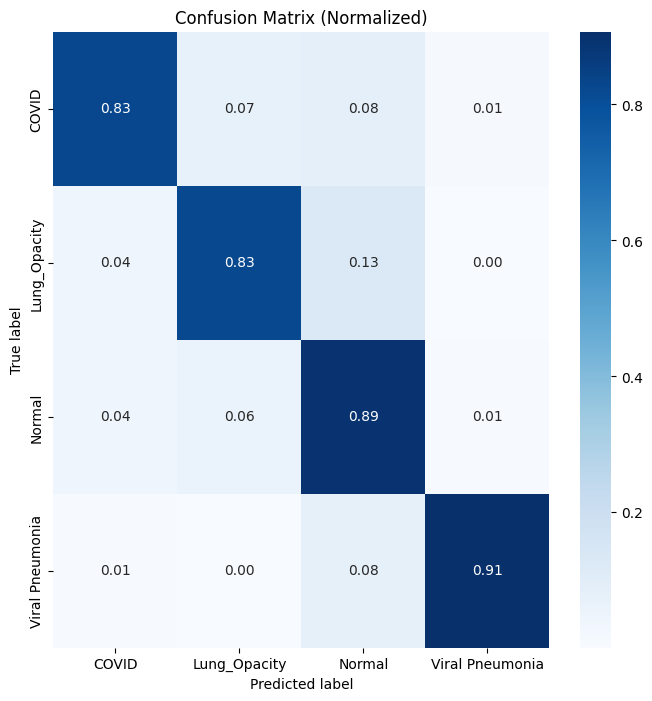

In [32]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix (Normalized)')
plt.show()

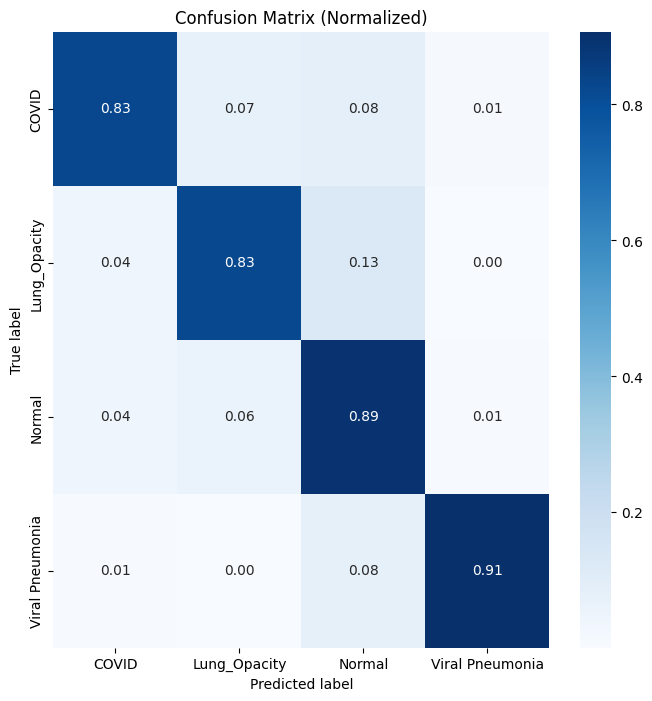

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred_classes, class_indices, save_path):
    cm = confusion_matrix(y_true, y_pred_classes)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_indices, yticklabels=class_indices)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix (Normalized)')

    # Save the figure to an SVG file
    plt.savefig(save_path, format='svg')

    # Show the plot
    plt.show()

# Assuming 'y_true' and 'y_pred_classes' are your true labels and predicted class labels, respectively
# Assuming 'test_generator.class_indices' contains the class labels
class_indices = list(test_generator.class_indices.keys())

# Specify the path where you want to save the SVG file
save_path = 'D:\\AI in Cytopathology\\Dataset\\COVID\\confusion_matrix.svg'

# Call the plot_confusion_matrix function with the appropriate parameters
plot_confusion_matrix(y_true, y_pred_classes, class_indices, save_path)



530/530 [==============================] - 39s 74ms/step


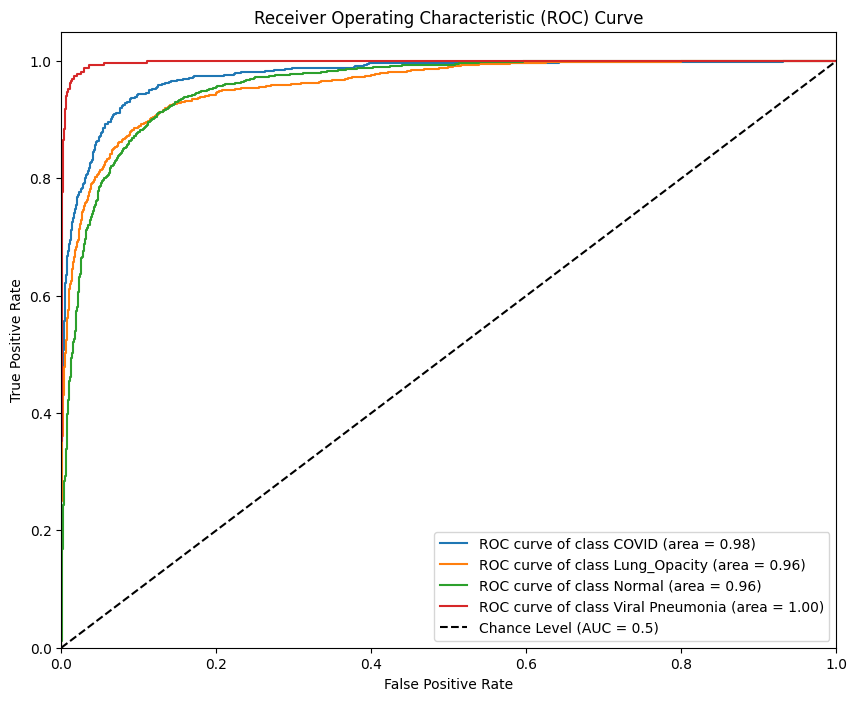

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
n_classes = len(class_indices)  # Number of classes
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

# Get the predicted probabilities for each class
y_pred_prob = model.predict(test_generator)  # Use model.predict_proba if your model supports it

# Initialize the figure
plt.figure(figsize=(10, 8))

# Calculate ROC curve and ROC area for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve of class {class_indices[i]} (area = {roc_auc:.2f})')

# Plot the diagonal line for chance level
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [35]:
# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))

                 precision    recall  f1-score   support

          COVID       0.81      0.83      0.82       723
   Lung_Opacity       0.85      0.83      0.84      1203
         Normal       0.88      0.89      0.89      2038
Viral Pneumonia       0.91      0.91      0.91       269

       accuracy                           0.86      4233
      macro avg       0.86      0.86      0.86      4233
   weighted avg       0.86      0.86      0.86      4233



In [36]:
# F1 Score
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.2f}')

F1 Score: 0.86
